# Article Relevance Prediction for NeotomaDB
## 2. Baseline Model with BOW Features

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Decisions on Features
3. Make preprocessing pipeline & Run baseline models with BOW features & Model Comparison
4. Feature Selection
5. Model evaluation
6. Summary

## 1. Data Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
pd.set_option("display.max_colwidth", 200)

In [2]:
# load csv
metadata_df = pd.read_csv("../../data/article-relevance/processed/metadata_processed.csv", index_col=0)
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4434 entries, 0 to 4461
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     4434 non-null   object
 1   URL                     4434 non-null   object
 2   abstract                2080 non-null   object
 3   author                  3977 non-null   object
 4   container-title         4427 non-null   object
 5   is-referenced-by-count  4434 non-null   int64 
 6   language                4434 non-null   object
 7   published               4434 non-null   object
 8   publisher               4430 non-null   object
 9   subject                 4346 non-null   object
 10  subtitle                4434 non-null   object
 11  title                   4434 non-null   object
 12  target                  4434 non-null   int64 
 13  published_year          4434 non-null   int64 
 14  title_clean             4434 non-null   object
 15  subt

In [3]:
metadata_df.head(1)

,DOI,URL,abstract,author,container-title,is-referenced-by-count,language,published,publisher,subject,...,target,published_year,title_clean,subtitle_clean,abstract_clean,subject_clean,has_abstract,text_with_abstract,text_wo_abstract,detectlang
0,10.2478/s11756-007-0072-x,http://dx.doi.org/10.2478/s11756-007-0072-x,NaN,"[{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...",Biologia,13,en,"{'date-parts': [[2006, 12]]}",Springer Science and Business Media LLC,"['Cell Biology', 'Plant Science', 'Genetics', 'Molecular Biology', 'Animal Science and Zoology', 'Biochemistry', 'Ecology, Evolution, Behavior and Systematics']",...,1,2006,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",NaN,NaN,"Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics",1,"The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest","The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest",en


## 2. Decisions on Features

| Variable | Description | Preprocessing |
| --- | --- | --- |
| DOI | Digital Object Identifier | Drop it during training. |
| URL | Link to the article | Drop it during training.|
|abstract | Abstract of the article. Only a small proportion of NeotomaDB articles has it. | Concatenate with title, then convert to Bag of Words representation|
|author | Author of the article | Consider droping due to duplicate names and various format and spelling |
|container-title | Title of the article's container | Decision: to make the model more generalizable to new journals, we will remove this feature. This also helps with dimension reduction with low cost of model performance. The subject feature is kept as a proxy of journal. |
| **is-referenced-by-count**| Count of the article being referenced by other article | Keep as a numeric feature.|
| language | Language of the article | Keep as a feature. Imputed with langdetect when missing. Only English articles are kept.|
| published | contain datatime information about when the article is published. | Decision: Drop the year of publication since it is not deemed as an informative feature.|
| publisher | Publisher name | Decision: drop to reduce dimension, and it is not a very informative feature. |
| **subject**| What subject the **journal** is about. | Keep as categorical feature. Bag of Words feature. |
| subtitle | Subtitle | Concatenate with title and then convert to Bag of words feature.|
| title | Title of the article. | Concatenate with title and abstract, then convert to Bag of words feature|
| **has_abstract** | Binary indicator.| Binary OHE feature.|
| **text_with_abstract** | Concatenated text: title + subtitle + abstract| BOW feature|
| text_wo_abstract | Concatenated text: title + subtitle (for experimental purpose) | Decision: We will use information from abstract to make better prediction.|
| detectlang | Imputed language using 'text_with_abstract' and detectlang package. | Value is used to impute missing language. Can be dropped now.|






In [4]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4434 entries, 0 to 4461
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4434 non-null   int64 
 1   has_abstract            4434 non-null   int64 
 2   subject_clean           4346 non-null   object
 3   text_with_abstract      4434 non-null   object
 4   target                  4434 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 207.8+ KB


In [5]:
# Replace Missing value in subject_clean to empty string to avoid error in BOW transformer
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna('')
metadata_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4434 entries, 0 to 4461
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4434 non-null   int64 
 1   has_abstract            4434 non-null   int64 
 2   subject_clean           4434 non-null   object
 3   text_with_abstract      4434 non-null   object
 4   target                  4434 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 207.8+ KB


In [6]:
metadata_df_cleaned = metadata_df_cleaned.reset_index().drop(columns="index")
metadata_df_cleaned.tail(2)

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
4432,4,0,,"Clinical and radiological characteristics of COVID-19: a multicentre, retrospective, observational study Multicentre cohort investigations of patients with coronavirus disease 2019 (COVID-19) hav...",0
4433,9,0,Multidisciplinary,"Survival of forensic trace evidence on improvised explosive devices: perspectives on individualisation Improvised Explosive Devices (IEDs) are weapons of modern times, used by terrorist groups an...",0


## 3. Baseline Model with BOW Features

### 3.0 Imports

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### 3.1 Train-Test Split

Decisions:
- We choose to allocate 30% of the data to test data. Since 4435 articles is not a very large amount of articles, we'd like to allocate more data to the training process.

In [9]:
train_df, val_test_df = train_test_split(metadata_df_cleaned, test_size=0.3, random_state=123)
valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=123)

### 3.2 EDA for Train Split

In [10]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 4221 to 3582
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  3103 non-null   int64 
 1   has_abstract            3103 non-null   int64 
 2   subject_clean           3103 non-null   object
 3   text_with_abstract      3103 non-null   object
 4   target                  3103 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 145.5+ KB


In [11]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [12]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)


With Abstract
748.9921507064364
858.006893755069


In [13]:
sorted_pos_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
362,2,1,,Descriptions of WHOI sediment cores,1
436,3,1,"Plant Science Ecology, Evolution, Behavior and Systematics","5. Kožlí (S. Bohemia, Czech Republic)",1
438,28,1,Atmospheric Science,Trees and climatic history in scotland,1
194,33,1,Geology,"Tropical Lakes, Copropel, and Oil Shale",1
210,5,1,"Ecology, Evolution, Behavior and Systematics",Polar Bear and Mammoth on the Pribilof Islands,1


In [14]:
sorted_neg_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target
1557,0,1,Computational Theory and Mathematics Computer Networks and Communications Computer Science Applications Theoretical Computer Science Software,Note,0
960,0,1,General Medicine Small Animals,Index,0
1724,0,1,Economics and Econometrics,Reply,0
933,0,1,Space and Planetary Science Aerospace Engineering,Awards,0
2332,0,1,Small Animals,Errata,0


#### Word Cloud

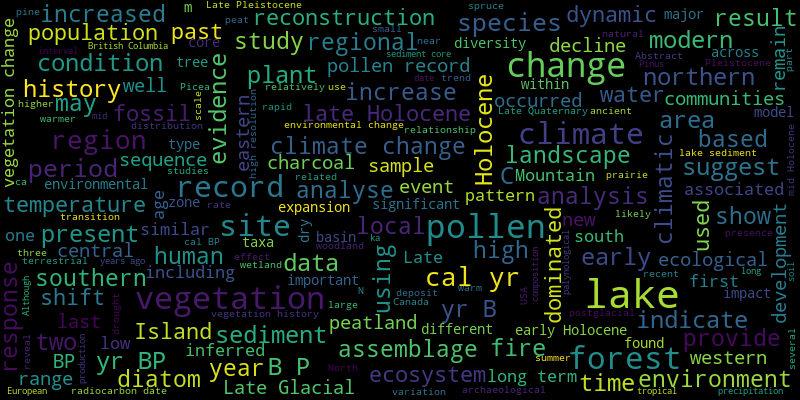

In [15]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

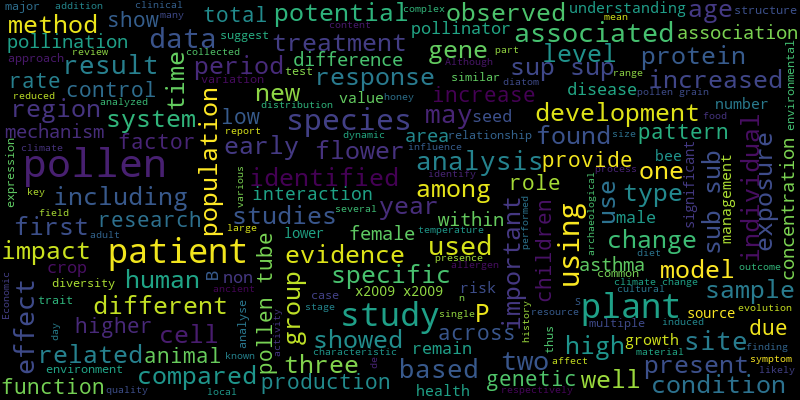

In [16]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [17]:
train_df["target"].value_counts(normalize=True)

0    0.794715
1    0.205285
Name: target, dtype: float64

## 3.3 Define Preprocessor

In [18]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target'],
      dtype='object')

In [19]:
X_train, y_train = train_df.drop(columns = ["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns = ["target"]), test_df["target"]
X_valid, y_valid = valid_df.drop(columns = ["target"]), valid_df["target"]

In [20]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

subject_feature = 'subject_clean'
subject_transformer = CountVectorizer(stop_words="english", max_features= 1000)

text_feature = "text_with_abstract"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprossor", binary_transformer, binary_feature),
    ("subject_preprocessor", text_transformer, subject_feature),
    ("text_preprocessor", text_transformer, text_feature)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprossor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('subject_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean'),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'text_with_abstract')])

##### Check Transformed Data

In [21]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

<3103x1320 sparse matrix of type '<class 'numpy.float64'>'
	with 98498 stored elements in Compressed Sparse Row format>

In [22]:
col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["binary_preprossor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["subject_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist()
             )
len(col_names)

1320

In [23]:
# Number of features from descriptive text 
len(preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist())

1000

In [24]:
# Number of features from subject
len(preprocessor.named_transformers_["subject_preprocessor"].get_feature_names_out().tolist())

318

In [25]:
transformed_X_train_df = pd.DataFrame.sparse.from_spmatrix(transformed_X_train, columns=col_names)
transformed_X_train_df.head()

,is-referenced-by-count,has_abstract_1,accounting,administration,advanced,aerospace,aging,agricultural,agronomy,aided,...,xa0,xb0,xb1,xe9,year,years,yield,younger,yr,zone
0,-0.224594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
1,-0.377734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.301164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.377734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.377734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.4 Baseline Models Comparison

In [26]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [27]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [28]:
classification_metrics = ["recall", "f1","precision", "accuracy"]

In [29]:
results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    'Logistic Regression': LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB(),
    "RBF SVM": SVC(class_weight="balanced", random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(class_weight="balanced", random_state=123),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=123),
    'XGBoost': XGBClassifier(class_weight="balanced", random_state=123, verbosity=0),
    # 'sklearn_histGB': HistGradientBoostingClassifier(class_weight="balanced", random_state=123),
    # 'sklearn_GB': GradientBoostingClassifier( random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, 
                                                  scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_precision,train_precision,test_accuracy,train_accuracy
dummy,0.226 (+/- 0.019),0.056 (+/- 0.006),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.795 (+/- 0.001),0.795 (+/- 0.000)
Logistic Regression,0.255 (+/- 0.004),0.051 (+/- 0.003),0.876 (+/- 0.034),0.996 (+/- 0.001),0.863 (+/- 0.028),0.990 (+/- 0.002),0.851 (+/- 0.037),0.984 (+/- 0.005),0.943 (+/- 0.012),0.996 (+/- 0.001)
Decision Tree,0.287 (+/- 0.018),0.053 (+/- 0.002),0.834 (+/- 0.038),1.000 (+/- 0.000),0.804 (+/- 0.017),1.000 (+/- 0.000),0.779 (+/- 0.026),1.000 (+/- 0.000),0.917 (+/- 0.007),1.000 (+/- 0.000)
kNN,0.255 (+/- 0.031),0.570 (+/- 0.038),0.747 (+/- 0.027),0.803 (+/- 0.006),0.740 (+/- 0.023),0.807 (+/- 0.004),0.733 (+/- 0.032),0.810 (+/- 0.012),0.892 (+/- 0.010),0.921 (+/- 0.002)
Naive Bayes,0.239 (+/- 0.063),0.052 (+/- 0.004),0.898 (+/- 0.027),0.919 (+/- 0.008),0.839 (+/- 0.017),0.855 (+/- 0.006),0.788 (+/- 0.017),0.800 (+/- 0.005),0.929 (+/- 0.008),0.936 (+/- 0.003)
RBF SVM,0.769 (+/- 0.061),0.195 (+/- 0.015),0.835 (+/- 0.041),0.963 (+/- 0.005),0.838 (+/- 0.027),0.947 (+/- 0.007),0.842 (+/- 0.038),0.933 (+/- 0.010),0.934 (+/- 0.012),0.978 (+/- 0.003)
RF,0.744 (+/- 0.033),0.067 (+/- 0.001),0.818 (+/- 0.035),1.000 (+/- 0.000),0.878 (+/- 0.017),1.000 (+/- 0.000),0.948 (+/- 0.010),1.000 (+/- 0.000),0.953 (+/- 0.005),1.000 (+/- 0.000)
LGBM,0.427 (+/- 0.012),0.069 (+/- 0.002),0.871 (+/- 0.036),1.000 (+/- 0.000),0.882 (+/- 0.019),1.000 (+/- 0.000),0.894 (+/- 0.020),1.000 (+/- 0.000),0.952 (+/- 0.007),1.000 (+/- 0.000)
CatBoost,4.602 (+/- 0.083),0.062 (+/- 0.003),0.807 (+/- 0.028),0.964 (+/- 0.006),0.874 (+/- 0.012),0.982 (+/- 0.003),0.954 (+/- 0.021),1.000 (+/- 0.000),0.952 (+/- 0.004),0.993 (+/- 0.001)
XGBoost,0.555 (+/- 0.069),0.076 (+/- 0.003),0.841 (+/- 0.040),0.993 (+/- 0.004),0.879 (+/- 0.018),0.996 (+/- 0.002),0.922 (+/- 0.026),1.000 (+/- 0.000),0.953 (+/- 0.006),0.998 (+/- 0.001)


##### Summary
- Test Recall: Naive Bayes > LGBM > Logistic regression > RF
- Test Precision: RF > SVM > LGBM > Logistic regression
- Test f1: RF ~ LGBM > Logistic regression > Naive Bayes > SVM
- Model overfit: there are signs of overfit, require hyperparameter tuning and feature selection

Since Gradient Boosted trees seem to perform well on our dataset, XGboost, catboost, sklearn's hist gradient boost and gradient boost are added to the list as an experiment. 

LGBM remains to be the best performing model of all gradient boosted model.

Naive Bayes' low precision will result in too many false positives so we do not go with this model.

In the next few steps, we will focus on logistic regression and LGBM. 


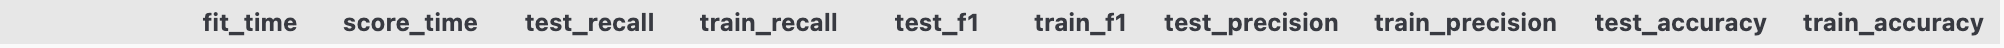

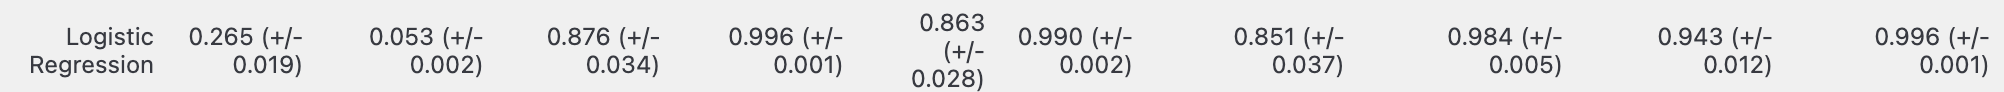

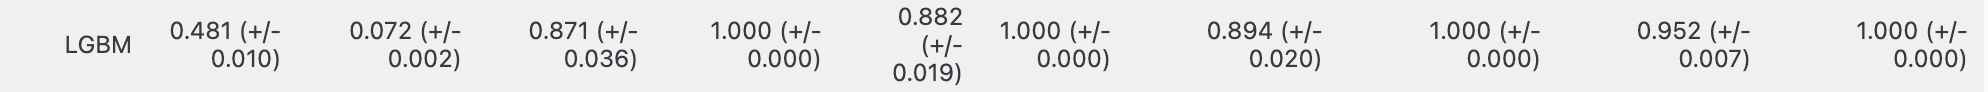

## 4. Feature Selection

### 4.1 Feature Selection on Various Models
Based on the initial results, we will apply feature selection to selected models.

Use logisitic regression for classification, L1 regularization to enable feature selection. Pass the feature with non-zero coefficient to the model. 


In [34]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000, random_state= 123)
        ),
        model,
    )
    results_dict[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

In [35]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_precision,train_precision,test_accuracy,train_accuracy
dummy,0.234 (+/- 0.022),0.057 (+/- 0.007),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.795 (+/- 0.001),0.795 (+/- 0.000)
Logistic Regression,0.265 (+/- 0.019),0.053 (+/- 0.002),0.876 (+/- 0.034),0.996 (+/- 0.001),0.863 (+/- 0.028),0.990 (+/- 0.002),0.851 (+/- 0.037),0.984 (+/- 0.005),0.943 (+/- 0.012),0.996 (+/- 0.001)
Decision Tree,0.300 (+/- 0.042),0.053 (+/- 0.002),0.834 (+/- 0.038),1.000 (+/- 0.000),0.804 (+/- 0.017),1.000 (+/- 0.000),0.779 (+/- 0.026),1.000 (+/- 0.000),0.917 (+/- 0.007),1.000 (+/- 0.000)
kNN,0.259 (+/- 0.029),0.571 (+/- 0.036),0.747 (+/- 0.027),0.803 (+/- 0.006),0.740 (+/- 0.023),0.807 (+/- 0.004),0.733 (+/- 0.032),0.810 (+/- 0.012),0.892 (+/- 0.010),0.921 (+/- 0.002)
Naive Bayes,0.228 (+/- 0.026),0.052 (+/- 0.003),0.898 (+/- 0.027),0.919 (+/- 0.008),0.839 (+/- 0.017),0.855 (+/- 0.006),0.788 (+/- 0.017),0.800 (+/- 0.005),0.929 (+/- 0.008),0.936 (+/- 0.003)
RBF SVM,0.767 (+/- 0.055),0.195 (+/- 0.015),0.835 (+/- 0.041),0.963 (+/- 0.005),0.838 (+/- 0.027),0.947 (+/- 0.007),0.842 (+/- 0.038),0.933 (+/- 0.010),0.934 (+/- 0.012),0.978 (+/- 0.003)
RF,0.738 (+/- 0.022),0.067 (+/- 0.002),0.818 (+/- 0.035),1.000 (+/- 0.000),0.878 (+/- 0.017),1.000 (+/- 0.000),0.948 (+/- 0.010),1.000 (+/- 0.000),0.953 (+/- 0.005),1.000 (+/- 0.000)
LGBM,0.481 (+/- 0.010),0.072 (+/- 0.002),0.871 (+/- 0.036),1.000 (+/- 0.000),0.882 (+/- 0.019),1.000 (+/- 0.000),0.894 (+/- 0.020),1.000 (+/- 0.000),0.952 (+/- 0.007),1.000 (+/- 0.000)
CatBoost,4.776 (+/- 0.055),0.062 (+/- 0.002),0.807 (+/- 0.028),0.964 (+/- 0.006),0.874 (+/- 0.012),0.982 (+/- 0.003),0.954 (+/- 0.021),1.000 (+/- 0.000),0.952 (+/- 0.004),0.993 (+/- 0.001)
XGBoost,0.525 (+/- 0.027),0.074 (+/- 0.003),0.841 (+/- 0.040),0.993 (+/- 0.004),0.879 (+/- 0.018),0.996 (+/- 0.002),0.922 (+/- 0.026),1.000 (+/- 0.000),0.953 (+/- 0.006),0.998 (+/- 0.001)


### 4.2 Investigate Selected Features

- Originally, transformed X_train has 1325 input features. 
- Logistic regression with L1 regularization results reduce the input dimension to 322.

> Model Performance comparison:

- Logistic Regression: 
    - test recall is 0.876, precision is 0.851, f1 is 0.863.
- Feature Selection + Logistic Regression
    - test recall is 0.862, precision is 0.826, f1 is 0.843.

No improving the recall on test set. Thus we will not go with feature selection to maximize the classification metrics.


- Feature Selection + LGBM shows similar pattern

In [37]:
pipe_fs = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["LGBM"],
)

pipe_fs.fit(X_train, y_train)

print(
    "Number of features selected: ",
    pipe_fs.named_steps["lgbmclassifier"].n_features_in_,
)

Number of features selected:  321


## 5. Model Evaluation

### 5.1 Logistic Regression without feature selection

- Decide to set the baseline model without feature selection to achieve higher recall and f1 scores

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprossor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('subject_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean'),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'text_with_abstract')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

#### 5.1.1 Classification Reports

In [39]:
logreg_model.classes_ # make sure which class is positive

array([0, 1])

In [42]:
from sklearn.metrics import classification_report
y_pred = logreg_model.predict(X_valid)

print(classification_report(y_valid, y_pred, target_names=["non-relevant", "relevant"]))


              precision    recall  f1-score   support

non-relevant       0.97      0.99      0.98       534
    relevant       0.95      0.89      0.92       131

    accuracy                           0.97       665
   macro avg       0.96      0.94      0.95       665
weighted avg       0.97      0.97      0.97       665



#### PR Curve

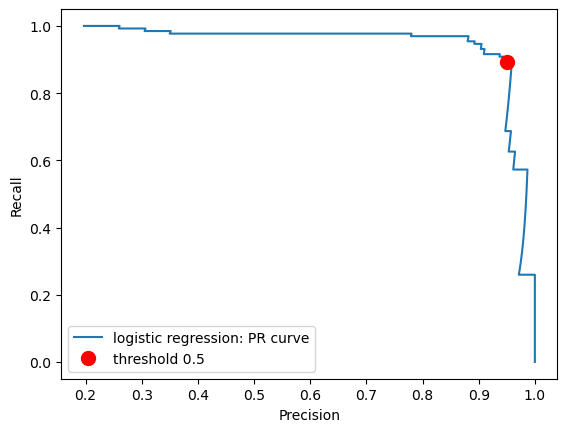

In [43]:
thresholds = np.arange(0.0, 1.0, 0.1)
precision, recall, thresholds = precision_recall_curve(
    y_valid, logreg_model.predict_proba(X_valid)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_valid, logreg_model.predict(X_valid)),
    recall_score(y_valid, logreg_model.predict(X_valid)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best")

#### ROC Curve

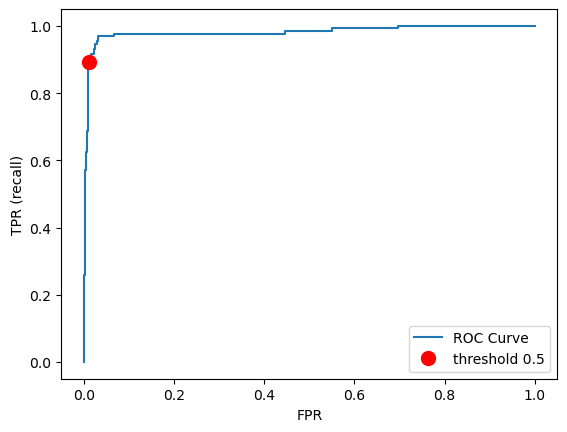

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, logreg_model.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

#### 5.1.2 Feature importance for Logistic Regression

In [46]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [47]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
archeology,1.874107,1.874107
lake,1.833928,1.833928
paleontology,1.694492,1.694492
plant,1.542399,1.542399
has_abstract_1,1.398021,1.398021
holocene,1.380636,1.380636
earth,1.350720,1.350720
canada,1.168333,1.168333
radiocarbon,1.152413,1.152413
vegetation,1.145887,1.145887


In [48]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
editorial,-1.522950,1.522950
sustainability,-1.318411,1.318411
econometrics,-1.230794,1.230794
economics,-1.230794,1.230794
mathematics,-1.172116,1.172116
issue,-1.098102,1.098102
main,-1.047314,1.047314
growth,-0.976586,0.976586
space,-0.948476,0.948476
influenza,-0.919224,0.919224


#### 5.1.3 Recall by group  (has abstract or not to see if the model is biased toward a certain group)

In [49]:
from sklearn.metrics import recall_score

# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

In [50]:
# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group 
print(grouped_recall)

has_abstract
0    1.000000
1    0.962319
dtype: float64


Calculate precision for each group

In [51]:
from sklearn.metrics import precision_score

grouped_precision = grouped_data.apply(lambda x: precision_score(x['target'], x['predictions']))
print(grouped_precision)

has_abstract
0    1.0
1    1.0
dtype: float64


### 5.2 LGBM without feature selection

In [52]:
lgbm_model = make_pipeline(preprocessor, LGBMClassifier(max_iter=1000, random_state=123))
lgbm_model.fit(X_train, y_train)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprossor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('subject_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean'),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'text_with_abstract')])),
                ('lgbmclassifier',
                 LGBMClassifier(max_iter=1000, random_state=123))])

In [53]:
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["non-relevant", "relevant"]))

              precision    recall  f1-score   support

non-relevant       0.97      0.99      0.98       523
    relevant       0.95      0.89      0.92       143

    accuracy                           0.97       666
   macro avg       0.96      0.94      0.95       666
weighted avg       0.97      0.97      0.97       666



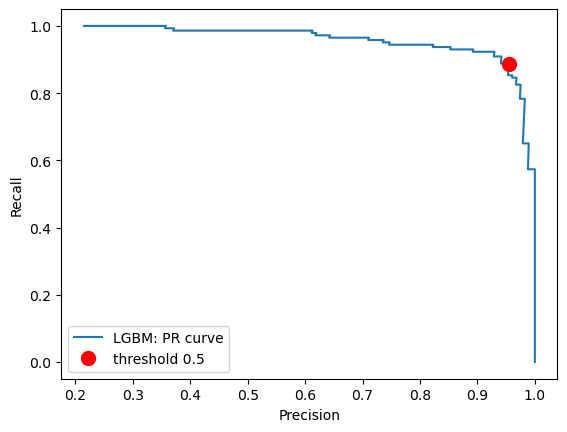

In [54]:
thresholds = np.arange(0.0, 1.0, 0.1)
precision, recall, thresholds = precision_recall_curve(
    y_test, lgbm_model.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="LGBM: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, lgbm_model.predict(X_test)),
    recall_score(y_test, lgbm_model.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best")

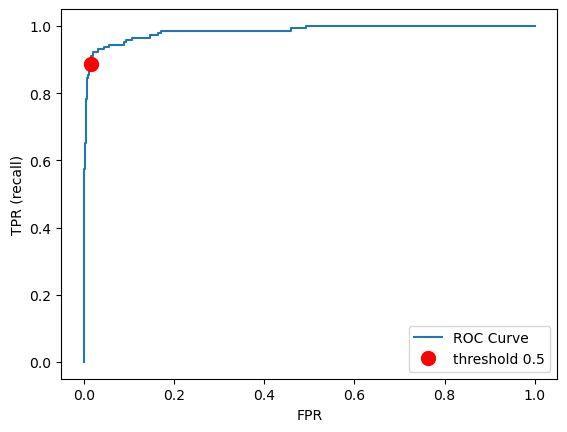

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, lgbm_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

#### 5.2.2 Feature importance for LGBM

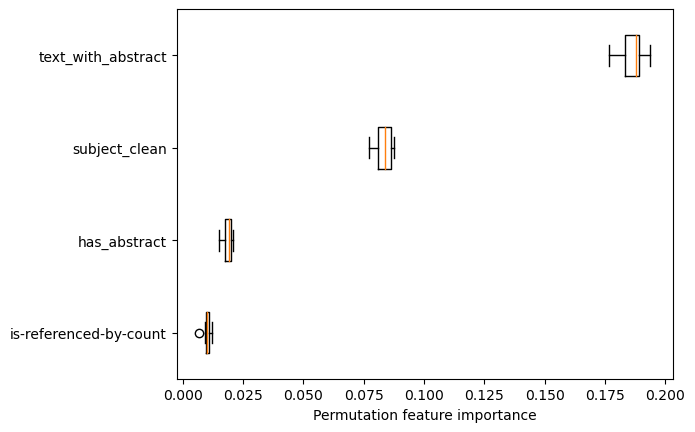

In [56]:
from sklearn.inspection import permutation_importance

def get_permutation_importance(model):
    result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=123)
    perm_sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X_train.columns[perm_sorted_idx],
    )
    plt.xlabel('Permutation feature importance')
    plt.show()
    
get_permutation_importance(lgbm_model)

#### 5.3 Model Mistakes

In [57]:
test_df['lr_pred'] = logreg_model.predict(X_test)
test_df['lgbm_pred'] = lgbm_model.predict(X_test)
test_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
564,5,1,"Paleontology Ecology, Evolution, Behavior and Systematics",Pollen–vegetation relationships at a tropical cloud forest's upper limit and accuracy of vegetation inference,1,1,1
1428,0,1,General Medicine,"ChemInform Abstract: Synthesis, Crystal Structure, and Vibrational Spectroscopy of the Alkali Diselenates A<sub>2</sub>Se<sub>2</sub>O<sub>7</sub>(A: Li-Cs).",0,0,0
3891,9,0,"General Agricultural and Biological Sciences General Biochemistry, Genetics and Molecular Biology General Medicine","Effect of cryopreservation on pollen viability, fertility and morphology of different Psidium species ""Cryopreservation of pollen is a complementary conservation strategy and can be used for cons...",0,0,0
4327,0,0,Inorganic Chemistry Organic Chemistry Physical and Theoretical Chemistry Computer Science Applications Spectroscopy Molecular Biology General Medicine Catalysis,Molecular Idiosyncratic Toxicology of Drugs in the Human Liver Compared with Animals: Basic Considerations Drug induced liver injury (DILI) occurs in patients exposed to drugs at recommended dose...,0,0,0
153,9,1,"Earth-Surface Processes Ecology, Evolution, Behavior and Systematics Global and Planetary Change","Late Wisconsin and Holocene Subalpine Forests of the Markagunt Plateau of Utah, Southwestern Colorado Plateau, U.S.A.",1,1,1


### 5.3.1 Logistic Regression FP & FN

In [58]:
# False Positives on Test Set
FP_LR = test_df.query('target == 0 & lr_pred == 1')
print(f'There are {FP_LR.shape[0]} False Positive in test set using Logistic regression')
FP_LR

There are 17 False Positive in test set using Logistic regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
3167,36,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Stable isotope paleoecology of Late Pleistocene Middle Stone Age humans from the Lake Victoria basin, Kenya Paleoanthropologists have long argued that environmental pressures played a key role in...",0,1,1
2938,0,0,"Genetics Ecology, Evolution, Behavior and Systematics","Taxonomic and functional dynamics during chytrid epidemics in an aquatic ecosystem ""Fungal parasitism is common in plankton communities and plays a crucial role in the ecosystem by balancing nutr...",0,1,0
4197,23,0,"Genetics Ecology, Evolution, Behavior and Systematics",Trade‐off between taxon diversity and functional diversity in European lake ecosystems Inferring ecosystem functioning and ecosystem services through inspections of the species inventory is a maj...,0,1,1
3380,10,0,Multidisciplinary,Early production of table olives at a mid-7th millennium BP submerged site off the Carmel coast (Israel) We present here the earliest evidence for large-scale table olive production from the mid-...,0,1,0
3927,1,0,Multidisciplinary,"The largest amber-preserved flower revisited Amber exquisitely preserves the delicate organs of fossil flowers for millions of years. However, flower inclusions can be rare and usually do not exc...",0,1,1
2809,14,0,Paleontology Earth-Surface Processes Ecology Archeology Global and Planetary Change,"Fuel remains in archaeological contexts: Experimental and archaeological evidence for recognizing remains in hearths used by Iron Age farmers who lived in peatlands In the archaeological record, ...",0,1,1
3628,10,0,Multidisciplinary,"Al-Ansab and the Dead Sea: Mid-MIS 3 archaeology and environment of the early Ahmarian population of the Levantine corridor ""Our field data from the Upper Palaeolithic site of Al-Ansab 1 (Jordan)...",0,1,1
2158,9,1,Environmental Science (miscellaneous) Archeology Archeology,Animal engravings in the central Sahara: A proxy of a proxy,0,1,0
3563,17,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Dietary evidence from Central Asian Neanderthals: A combined isotope and plant microremains approach at Chagyrskaya Cave (Altai, Russia) Neanderthals are known primarily from their habitation of ...",0,1,0
3044,15,0,"Anthropology Ecology, Evolution, Behavior and Systematics","The morphological affinity of the Early Pleistocene footprints from Happisburgh, England, with other footprints of Pliocene, Pleistocene, and Holocene age Fossil hominin footprints provide a dire...",0,1,0


In [59]:
# False Negatives on Test Set
FN_LR = test_df.query('target == 1 & lr_pred == 0')
print(f'There are {FN_LR.shape[0]} False Negative in test set using Logistic regression')
FN_LR

There are 20 False Negative in test set using Logistic regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
553,11,1,Geochemistry and Petrology Geophysics,"Eruption and mass-wasting-induced processes during the late holocene destructive phase of Nevado del Ruiz volcano, Colombia",1,0,1
77,0,1,,Summary report of the operations of the Geological Survey for the calendar year 1902,1,0,0
343,149,1,"General Physics and Astronomy General Biochemistry, Genetics and Molecular Biology General Chemistry Multidisciplinary",Mid-Pliocene warm-period deposits in the High Arctic yield insight into camel evolution,1,0,1
4255,4,0,Multidisciplinary,Integrative geochronology calibrates the Middle and Late Stone Ages of Ethiopia’s Afar Rift The Halibee member of the Upper Dawaitoli Formation of Ethiopia's Middle Awash study area features a we...,1,0,0
31,53,0,General Arts and Humanities Archeology,"Prehistoric human impacts on Rapa, French Polynesia New excavations and survey on the island of Rapa have shown that a rockshelter was occupied by early settlers around AD 1200 and the first hil...",1,0,1
3484,57,0,"General Physics and Astronomy General Biochemistry, Genetics and Molecular Biology General Chemistry Multidisciplinary","Holocene sea ice variability driven by wind and polynya efficiency in the Ross Sea The causes of the recent increase in Antarctic sea ice extent, characterised by large regional contrasts and dec...",1,0,1
315,51,1,"Management, Monitoring, Policy and Law Nature and Landscape Conservation Forestry","Holocene records of Dendroctonus bark beetles in high elevation pine forests of Idaho and Montana, USA",1,0,1
188,41,1,Water Science and Technology Aquatic Science,Effects of Small Ponds on Stream Water Chemistry,1,0,1
3243,2,1,"Library and Information Sciences Statistics, Probability and Uncertainty Computer Science Applications Education Information Systems Statistics and Probability","Addendum: FosSahul 2.0, an updated database for the Late Quaternary fossil records of Sahul",1,0,0
3701,3,0,Pollution Waste Management and Disposal Environmental Chemistry Environmental Engineering,"Anthropocene history of rich fen acidification in W Poland — Causes and indicators of change In the time of the global climate crisis, it is vital to protect and restore peatlands to maintain the...",1,0,1


### 5.3.2 LGBM FP & FN

In [60]:
# False Positives on Test Set
FP_LGBM = test_df.query('target == 0 & lgbm_pred == 1')
print(f'There are {FP_LGBM.shape[0]} False Positive in test set using LGBM regression')
FP_LGBM

There are 6 False Positive in test set using LGBM regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
3167,36,0,"Anthropology Ecology, Evolution, Behavior and Systematics","Stable isotope paleoecology of Late Pleistocene Middle Stone Age humans from the Lake Victoria basin, Kenya Paleoanthropologists have long argued that environmental pressures played a key role in...",0,1,1
4197,23,0,"Genetics Ecology, Evolution, Behavior and Systematics",Trade‐off between taxon diversity and functional diversity in European lake ecosystems Inferring ecosystem functioning and ecosystem services through inspections of the species inventory is a maj...,0,1,1
4391,8,1,Immunology Immunology and Allergy,"Climate change, airborne pollen, and pollution",0,0,1
3927,1,0,Multidisciplinary,"The largest amber-preserved flower revisited Amber exquisitely preserves the delicate organs of fossil flowers for millions of years. However, flower inclusions can be rare and usually do not exc...",0,1,1
2809,14,0,Paleontology Earth-Surface Processes Ecology Archeology Global and Planetary Change,"Fuel remains in archaeological contexts: Experimental and archaeological evidence for recognizing remains in hearths used by Iron Age farmers who lived in peatlands In the archaeological record, ...",0,1,1
3628,10,0,Multidisciplinary,"Al-Ansab and the Dead Sea: Mid-MIS 3 archaeology and environment of the early Ahmarian population of the Levantine corridor ""Our field data from the Upper Palaeolithic site of Al-Ansab 1 (Jordan)...",0,1,1


In [61]:
# False Positives on Test Set
FN_LGBM = test_df.query('target == 1 & lgbm_pred == 0')
print(f'There are {FN_LGBM.shape[0]} False Negative in test set using LGBM regression')
FN_LGBM

There are 16 False Negative in test set using LGBM regression


,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,lr_pred,lgbm_pred
77,0,1,,Summary report of the operations of the Geological Survey for the calendar year 1902,1,0,0
4255,4,0,Multidisciplinary,Integrative geochronology calibrates the Middle and Late Stone Ages of Ethiopia’s Afar Rift The Halibee member of the Upper Dawaitoli Formation of Ethiopia's Middle Awash study area features a we...,1,0,0
2612,13,0,Multidisciplinary,"Reimagining the relationship between Gondwanan forests and Aboriginal land management in Australia's “Wet Tropics” ""The """"Wet Tropics"""" of Australia host a unique variety of plant lineages that t...",1,1,0
3243,2,1,"Library and Information Sciences Statistics, Probability and Uncertainty Computer Science Applications Education Information Systems Statistics and Probability","Addendum: FosSahul 2.0, an updated database for the Late Quaternary fossil records of Sahul",1,0,0
626,78,0,Multidisciplinary,"Carbon starvation in glacial trees recovered from the La Brea tar pits, southern California \n The Rancho La Brea tar pit fossil collection includes\n Juniperus \n ...",1,1,0
4051,7,0,Multidisciplinary,"Central European Early Bronze Age chronology revisited: A Bayesian examination of large-scale radiocarbon dating In archaeological research, changes in material culture and the evolution of style...",1,1,0
615,4,1,,"The Hill-Shuler Local Faunas of the Upper Trinity River, Dallas and Denton Counties, Texas",1,0,0
2927,1,0,Multidisciplinary,Ecological flexibility and adaptation to past climate change in the Middle Nile Valley: A multiproxy investigation of dietary shifts between the Neolithic and Kerma periods at Kadruka 1 and Kadruk...,1,0,0
698,7,1,,In search of a palynological tundra,1,0,0
335,12,1,Geology,Centennial-scale trends in the Southern Annular Mode revealed by hemisphere-wide fire and hydroclimatic trends over the past 2400 years,1,0,0


# 6. Summary for Baseline Models

Benchmarks
- Logistic Regression with BOW text features
    - Precision 0.94
    - Recall 0.85
    - F1 0.89

- LGBM with BOW text features
    - Precision 0.92
    - Recall 0.83
    - F1 0.88

Notes:
- Adding has_abstract could help non-linear model to learn the non-linearity for articles with/without abstract. For linear model, it is also not dominating the prediction. 
- Threshold 0.5 could possibly be adjusted to optimize recall more (while keeping precison at a reasonably high level)